<a href="https://colab.research.google.com/github/AlexanderVerheecke/TwitterSentimentAnalysis/blob/main/MBERT_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to run:
The dataset used in this colab file is taken from my personal google Drive folder. I was unable to link the gitlab file to here. If the system is not connected to my Google Drive folder, the user will need to download the 
datasets themselves from : https://drive.google.com/drive/folders/1hxBtAXu-IfoajBtJIG_8q7lFcmcLWYJu?usp=sharing 

- MIX: Data -> MBERT COMBINED -> Train_data_GERandENG_SHUFFLED.csv

Further, since trainign the model will take a long time, it was saved andnloaded in for easier performance checking. The model can be loaded from:
https://drive.google.com/drive/folders/1Yj06VqsfPMaTlfnJEdInLKYXmd4c7nch?usp=sharing

The model to load is USE_MBERT_FINAL. The path to the model should be inserted under "RESULTS TO COMPARE" as:


```
FINAL_LOADED_BERT = tf.keras.models.load_model('PATH TO MODEL')
```



The dataset and model will need to be uploaded to Colabs files folder on left and the file path copied to the respective dataset reading.

Once the dataset and model are imported correctly, the user will need to run ONLY the cells under " === RESULTS WITH LOADED MODEL ===" unless the user wants to trained the whole model from the beginning. In this case, 'run all' under 'runtime' will suffice.

Under "RESULTS WITH LOADED MODELS", the cells will import the necessary libraries and initiaite the functions as well as read the various datasets, then give the results.

Results for German vs English translations are under "== GERMAN VS ENGLISH TRANSLATION ==" and English vs German Translations udner "== ENGLISH VS GERMAN TRANSLATION ==". For each section and dataset, a dataframe is printed indicating the true labels, the  predicted lables, and the tweets

# ==== LIBRARY IMPORTS AND DATA READING/FORMATING ====

In [ ]:
#When first running this notebook after a disconnection, install the librarues before importing
!pip install transformers
!pip install tensorflow
!pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 29.2 MB/s 
     |████████████████████████████████| 6.6 MB 54.1 MB/s 
     |████████████████████████████████| 120 kB 88.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 27.1 MB/s 
     |████████████████████████████████| 511.7 MB 6.0 kB/s 
     |████████████████████████████████| 1.6 MB 77.2 MB/s 
     |████████████████████████████████| 5.8 MB 65.8 MB/s 
     |████████████████████████████████| 438 kB 83.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensor

In [ ]:
import pandas as pd
import numpy as np


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [ ]:
# SemEval = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/SemEval2017/SemEval2017_DataSet.csv')
# SemEval = pd.DataFrame(SemEval)
# SemEval = SemEval[['Sentiment', 'Tweet']]
# labelling = {-1: 0, 0:1, 1:2}
# SemEval['Sentiment'] = SemEval['Sentiment'].map(labelling)


# Mixed data from SemEval and German_Unqiue for Bert Training
mix = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/MBERT COMBINED/Train_data_GERandENG_SHUFFLED.csv')
mix = pd.DataFrame(mix)
mix = mix[['Sentiment', 'Tweet']]
labelling = {-1: 0, 0:1, 1:2}
mix['Sentiment'] = mix['Sentiment'].map(labelling)

# ====== MODEL CREATION AND TRAINING ======

In [ ]:
#SemEval
# train = SemEval[:9213]
# test = SemEval[9214:]

#Mixed
train = mix[:10548]
test = mix[10549:]

train_tweet = train.Tweet
train_label = train.Sentiment

test_tweet = test.Tweet
test_label = test.Sentiment

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(train_label,num_classes = 3)

y_test = to_categorical(test_label,num_classes = 3)

In [ ]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
bert = TFBertModel.from_pretrained('bert-base-multilingual-cased')

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=train.Tweet.tolist(),
    add_special_tokens=True,      # adds [CLS] and [SEP] to ends of each sentence
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',      # return out input tensor as valid for tensorflow model
    return_token_type_ids = False, # bert doesn't need token_type_ids
    return_attention_mask = True, # bertneeds  need attention_mask
    verbose = True)

x_test = tokenizer(
    text=test.Tweet.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',      # return out input tensor as valid for tensorflow model
    return_token_type_ids = False,   # bert doesn't need token_type_ids
    return_attention_mask = True,   # bertneeds  need attention_mask
    verbose = True)

In [ ]:

input_ids = x_train['input_ids']
# input_ids
attention_mask = x_train['attention_mask']
# attention_mask

In [ ]:

max_len = 70
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert.bert(input_ids,attention_mask = input_mask)[0] #only passing unput ods and attension mask, noyo token_type_ids
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
y = Dense(3,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True




In [ ]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = 'CategoricalCrossentropy', 
    metrics = ['accuracy'])

In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0.01,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True,
                          mode='min')

train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=5,
    batch_size=32,
    callbacks= earlystop
)

Epoch 1/5


330/330 [==============================] - 190s 512ms/step - loss: 0.8065 - accuracy: 0.6269 - val_loss: 0.5579 - val_accuracy: 0.7556
Epoch 2/5
330/330 [==============================] - 171s 518ms/step - loss: 0.5842 - accuracy: 0.7392 - val_loss: 0.4544 - val_accuracy: 0.8086
Epoch 3/5
330/330 [==============================] - 171s 519ms/step - loss: 0.4617 - accuracy: 0.8020 - val_loss: 0.3913 - val_accuracy: 0.8455
Epoch 4/5
330/330 [==============================] - 171s 519ms/step - loss: 0.3740 - accuracy: 0.8451 - val_loss: 0.3481 - val_accuracy: 0.8680
Epoch 5/5
330/330 [==============================] - 171s 517ms/step - loss: 0.3057 - accuracy: 0.8797 - val_loss: 0.3402 - val_accuracy: 0.8836


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  177853440   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            

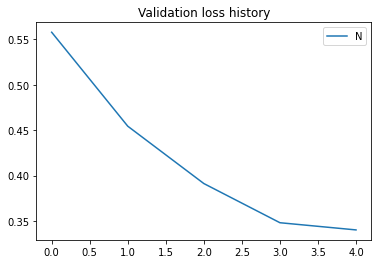

In [ ]:
import matplotlib.pyplot as plt
plt.title('Validation loss history')
plt.plot(train_history.history['val_loss'])
plt.legend('No. epochs')
plt.show();

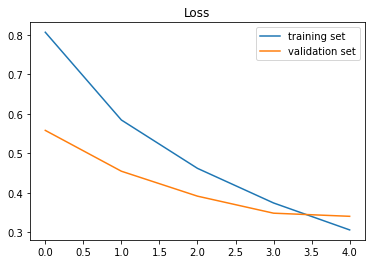

In [ ]:
plt.title('Loss')
plt.plot(train_history.history['loss'], label='training set')
plt.plot(train_history.history['val_loss'], label='validation set')
plt.legend()
plt.show();

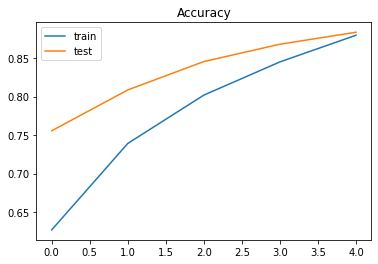

In [ ]:
plt.title('Accuracy')
plt.plot(train_history.history['accuracy'], label='train')
plt.plot(train_history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


In [ ]:
evaluation = model.evaluate({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test)


55/55 [==============================] - 8s 151ms/step - loss: 0.3402 - accuracy: 0.8836


In [ ]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})


55/55 [==============================] - 11s 148ms/step


In [ ]:
predicted_raw

array([[8.8693684e-01, 1.1258729e-01, 4.7593322e-04],
       [1.3094330e-05, 9.2509674e-04, 9.9906176e-01],
       [9.3333137e-01, 6.6130325e-02, 5.3833553e-04],
       ...,
       [5.9546452e-02, 9.3957841e-01, 8.7512750e-04],
       [9.9451822e-01, 4.4954238e-03, 9.8642299e-04],
       [9.7358759e-05, 6.2682555e-04, 9.9927586e-01]], dtype=float32)

In [ ]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = test.Sentiment


In [ ]:

look =  set(y_predicted) -set(y_true) 
look

set()

In [ ]:
unique_pred = np.unique(y_predicted)
unique_pred

array([0, 1, 2])

In [ ]:
unique_true= np.unique(y_true)
unique_true

array([0, 1, 2])

In [ ]:
from sklearn.metrics import classification_report
print("===== on itself as test data =====")
print(classification_report(y_true, y_predicted))


===== on itself as test data =====
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       568
           1       0.86      0.90      0.88       821
           2       0.90      0.88      0.89       346

    accuracy                           0.88      1735
   macro avg       0.89      0.88      0.88      1735
weighted avg       0.88      0.88      0.88      1735



In [ ]:
print(" ========= MIX =========\n")
get_results(mix, model)

 ========= MIX =========

440/440 [==============================] - 66s 150ms/step
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      4243
           1       0.88      0.91      0.89      7077
           2       0.87      0.86      0.87      2745

    accuracy                           0.88     14065
   macro avg       0.89      0.88      0.88     14065
weighted avg       0.88      0.88      0.88     14065



In [ ]:
# model.save('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Models/ReportModels/USE_MBERT_FINAL')

# ========= RESULTS WITH LOADED MODEL========

In [ ]:
!pip install transformers
!pip install tensorflow
!pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text


import pandas as pd
import numpy as np

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Function to get prediction results

In [ ]:
from transformers import AutoTokenizer,TFBertModel
from sklearn.metrics import classification_report
import numpy as np
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')
bert = TFBertModel.from_pretrained('bert-base-multilingual-cased')

def get_results(DataFrame, model):
  test = tokenizer(
    text=DataFrame.Tweet.tolist(),
    add_special_tokens=True,      # adds [CLS] and [SEP] to ends of each sentence
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',      # return out input tensor as valid for tensorflow model
    return_token_type_ids = False, # bert doesn't need token_type_ids
    return_attention_mask = True, # bertneeds  need attention_mask
    verbose = True)
  
  predicted_raw = model.predict({'input_ids':test['input_ids'],'attention_mask':test['attention_mask']})


  test_y_predicted = np.argmax(predicted_raw, axis = 1)
  test_y_true = DataFrame.Sentiment

  # print(classification_report(test_y_true, test_y_predicted))
  REPORT = classification_report(test_y_true, test_y_predicted)

  return REPORT, test_y_true, test_y_predicted,

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# RESULTS TO COMPARE

In [ ]:
import pandas as pd


# Data to compare for thesis
English_latest = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/OwnTweets/English/latestEnglish.csv')
English_latest = pd.DataFrame(English_latest)

English_translation = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/OwnTweets/latestGermanTranlatedToEnglish.csv')
English_translation = pd.DataFrame(English_translation
                                 )
German_latest = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/OwnTweets/German/latestGerman.csv')
German_latest = pd.DataFrame(German_latest)

German_translation = pd.read_csv('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Data/OwnTweets/German/latestEnglishTranslatedToGERMAN.csv')
German_translation = pd.DataFrame(German_translation)

labelling = {-1: 0, 0:1, 1:2}

English_latest['Sentiment'] = English_latest['Sentiment'].map(labelling)
English_translation['Sentiment'] = English_translation['Sentiment'].map(labelling)
German_latest['Sentiment'] = German_latest['Sentiment'].map(labelling)
German_translation['Sentiment'] = German_translation['Sentiment'].map(labelling)


In [ ]:
from tensorflow import keras
FINAL_LOADED_BERT = tf.keras.models.load_model('/content/drive/MyDrive/Education/University/Master/Classes/Thesis/Models/ReportModels/USE_MBERT_FINAL')

resultsLabelling = {0:-1, 1:0, 2:1}

In [ ]:
print(" ========= German  =========")
German_report, German_y_true, German_y_predicted = get_results(German_latest, FINAL_LOADED_BERT)

 ========= German  =========
30/30 [==============================] - 8s 146ms/step


In [ ]:
print(" ========= English translation =========")
English_translation_report, English_translation_y_true, English_translation_y_predicted = get_results(English_translation, FINAL_LOADED_BERT)

 ========= English translation =========
30/30 [==============================] - 4s 142ms/step


In [ ]:
print(" ========= German translation =========")
German_translation_report, German_translation_y_true, German_translation_y_predicted = get_results(German_translation, FINAL_LOADED_BERT)

 ========= German translation =========
31/31 [==============================] - 5s 149ms/step


In [ ]:
print(" ========= English  =========")
English_report, English_y_true, English_y_predicted = get_results(English_latest, FINAL_LOADED_BERT)

 ========= English  =========
31/31 [==============================] - 5s 149ms/step


# Classification Analysis

# ======== GERMAN VS ENGLISH TRANSLATION =========

# GERMAN NEG/NEU/POS TWEET EXAMPLE

MIX Bert classifies the follwoing three sentences with the correct lables

In [ ]:
dataframe_german_tweet = pd.DataFrame(German_latest["Tweet"])
dataframe_german_true = pd.DataFrame(German_y_true)
dataframe_german_pred = pd.DataFrame(German_y_predicted)
pd.set_option('display.max_colwidth', None)
sentiment_german = dataframe_german_true
sentiment_german['Predicted'] = dataframe_german_pred
sentiment_german['Tweet'] = dataframe_german_tweet


sentiment_german['Sentiment'] = sentiment_german['Sentiment'].map(resultsLabelling)
sentiment_german['Predicted'] = sentiment_german['Predicted'].map(resultsLabelling)



In [ ]:
sentiment_german.head(13)

,Sentiment,Predicted,Tweet
0,0,0,@Marcel126610 Irgendwie schon. Aber ...wer will ihn denn dann auch irgendwo rumsitzen haben...🤷‍♀️
1,0,-1,@PewPeeew aight nichts leichter als das
2,-1,-1,"@LibertyHannes @RikeWaldfee @MarcoBuschmann Uhhhhh echt jetzt "" ich darf töten wenn ich will"" mimimi 😭 und was mit euren Blagen ist, ist mir doch egal. Puh was ich dazu sage #FDPmachtkrankundarm und #FDPunter5Prozent . Ihr seit auf einen guten Weg . 😂 Ach #dielinke erholt sich gerade in den ersten Umfragen wider. 😂"
3,0,-1,"Unter #IhrHabtEuchSelbstAusgegrenzt meinte gerade ein Querdenker, es sollte doch konsequenzlos möglich sein sich nicht impfen zu lassen. Tja was soll ich sagen: Für Pfleger und Ärzte am Ende ihrer Kräfte war es auch nicht konsequenzlos, wenn Querdenker die Impfung verweigern."
4,0,0,"Und zur Sicherheit noch einmal: es geht hier um die Etikettierung, nicht das Testprodukt selbst. Kein Einfluss auf Ergebnis. https://t.co/Nne9nYSPgV"
5,1,0,"@MarcBrup @broennimann Welches Land findest Du inspirierend? (Ehrlich gemeinte Frage) Mich inspirieren Menschen, Natur, Musik, etc..aber ein ganzes Land?🤔 pS: ich bin sehr viel gereist, und könnte höchstens sagen, dass die unterschiedlichsten Menschen und Kulturen inspirierend waren. Die Vielfalt."
6,-1,0,@besserossi @deprecatedCode @kotzlpotzl @drlisamaria Leichenfledderei! 😠
7,-1,-1,"Ihr wurdet nie ausgegrenzt, ihr habt euch separiert Ihr habt auf die Solidargemeinschaft geschissen Ihr habt euch von Rechtsextremisten unterstützen lassen Ihr werdet in Geschichtsbüchern nicht als Opfer sondern als Täter stehen #wirhabenausgegrenzt #SolidaritaetmitderWoelfin"
8,-1,-1,"Der Anwalt Chan-jo Jun hat Twitter verlassen. Ständig forderte er, dass wir mehr tun im Bereich Hasskriminalität u. bekam sehr viele Morddrohungen. Verstehe, dass er jetzt genug hat. Tragisch ist sein Rückzug hier für unsere Demokratie dennoch. Hoffe sehr, er kommt zurück."
9,0,0,Günstiges #Russland-#Gas ist das beste Mittel gegen Vermögensfraß beim Bürger. Stattdessen kommen #Gruene mit #Gasumlage und anderen #Grunen Plagen.


# ENGLISH TRANSLATION NEG/NEU/POS TWEET EXAMPLE

MIX BERT classifies two of the abov sentences with teh correct label but fails to predict the correct label for the neutral tweet, instead classifying it as negative

In [ ]:
dataframe_english_trans_tweet = pd.DataFrame(English_translation["Tweet"])
dataframe_english_trans_true = pd.DataFrame(English_translation_y_true)
dataframe_english_trans_pred = pd.DataFrame(English_translation_y_predicted)
pd.set_option('display.max_colwidth', None)
sentiment_english_trans = dataframe_english_trans_true
sentiment_english_trans['Predicted'] = dataframe_english_trans_pred
sentiment_english_trans['Tweet'] = dataframe_english_trans_tweet

sentiment_english_trans.rename(columns={0	: "Sentiment"})

sentiment_english_trans['Sentiment'] = sentiment_english_trans['Sentiment'].map(resultsLabelling)
sentiment_english_trans['Predicted'] = sentiment_english_trans['Predicted'].map(resultsLabelling)


In [ ]:
sentiment_english_trans.head(25)

,Sentiment,Predicted,Tweet
0,0,0,@Marcel126610 Somehow yes. But...who wants it sitting around somewhere...🤷‍♀️
1,0,1,@PewPeeew aight nothing easier than that
2,-1,-1,"@LibertyHannes @RikeWaldfee @MarcoBuschmann Uhhhhh really now ""I can kill if I want"" mimimi 😭 and I don't care what's up with your brats. Puh what I say to #FDPmachtsickundarm and #FDPunter5Percent. You are on the right track. 😂 Oh #dielinke is recovering in the first polls. 😂"
3,0,-1,"Under #YourHaveYouselfExcluded, a lateral thinker said that it should be possible not to be vaccinated without any consequences. Well, what can I say: For nurses and doctors at the end of their strength, it was not without consequences when lateral thinkers refused to be vaccinated."
4,0,0,"And to be on the safe side again: this is about the labeling, not the test product itself. No influence on the result. https://t.co/Nne9nYSPgV"
5,1,1,"@MarcBrup @broennimann Which country do you find inspirational? (Honest question) I'm inspired by people, nature, music, etc.. but a whole country?🤔 PS: I've traveled a lot and could at most say that the most diverse people and cultures were inspiring. The diversity."
6,-1,0,@besserossi @deprecatedCode @kotzlpotzl @drlisamaria scavenging! 😠
7,-1,-1,"You were never excluded, you separated. You gave a shit about the community of solidarity. You let right-wing extremists support you. You will not appear in history books as a victim but as a perpetrator #we have excluded #SolidaritaetmitderWoelfin"
8,-1,-1,Lawyer Chan-jo Jun has left Twitter. He kept demanding that we do more on hate crime and received many death threats. Understand that he's had enough now. His withdrawal here is still tragic for our democracy. I really hope he comes back.
9,0,-1,"Cheap #Russia #gas is the best remedy against the citizens' wealth being eaten up. Instead, #greens come with #gas surcharges and other #green plagues."


# ======== ENGLISH VS GERMAN TRANSLATION =========

# ENGLISH NEG/NEU/POS TWEET EXAMPLE

MIX BERT classifies the following three sentences with the correct label

In [ ]:
dataframe_english_tweet = pd.DataFrame(English_latest['Tweet'])
dataframe_english_true = pd.DataFrame(English_y_true)
dataframe_english_pred = pd.DataFrame(English_y_predicted)
pd.set_option('display.max_colwidth', None)
sentiment_english = dataframe_english_true
sentiment_english['Predicted'] = dataframe_english_pred
sentiment_english["Tweet"] = dataframe_english_tweet

sentiment_english['Sentiment'] = sentiment_english['Sentiment'].map(resultsLabelling)
sentiment_english['Predicted'] = sentiment_english['Predicted'].map(resultsLabelling)

In [ ]:
sentiment_english.head(25)

,Sentiment,Predicted,Tweet
0,-1,-1,If you got ex drama please don’t hit me up ✌🏽
1,0,0,"If the World Bank wants to support the people, it must urge #Ethiopia to #EndTigraySiege and allow unhindered humanitarian access to #Tigray. #WorldBankStopFundingTigrayGenocide @SecBlinken @JosepBorrellF @WorldBank @UN_HRC @DavidMalpassWBG @IMFNews"
2,1,0,"Amusan and Duplantis, two athletes that broke records at Oregon 22 - https://t.co/z4ry6UPGgm"
3,0,0,FACT https://t.co/0ZJlCLlytP
4,0,0,220726 © 时尚先生Esquire — ESQUIRE China shares a teaser image of Wu Lei on the upcoming cover of ESQUIRE’s August issue! #吴磊 • #wulei • #leowu • #อู๋เหล่ย ࿐ https://t.co/lbm2HKv0Df
5,0,0,@_FacundoZapata Only listen to your soul!
6,1,1,@HibaycOfficial Good project with most potential and huge opportunity @malicknajim @FaridaZamou @JuniorS54441117 #NFTs #nftart #ETH #Hibayc #Airdrops
7,0,0,Jai Nice got engaged and nobody knows who her man even is… MOOD🥂
8,-1,-1,The Employment Tribunal found that Garden Court Chambers discriminated against me because of my gender critical belief when it published a statement that I was under investigation and in upholding Stonewall’s complaint against me. #AllisonBaileyWins
9,-1,-1,@fra27236945 @thatdayin1992 Why more than 80% of world population genuinely hate US/NATO/EU? Why do all of them so eagerly wait a moment of liberation? Russia is not alone. 80% of world is on Russia's side. The evil western empire will inevitably fall. The westerners cannot exploit the others for ever.


# GERMAN TRANSLATION NEG/NEU/POS TWEET EXAMPLE

In [ ]:
dataframe_german_translation_tweet = pd.DataFrame(German_translation['Tweet'])
dataframe_german_translation_true = pd.DataFrame(German_translation_y_true)
dataframe_german_translation_pred = pd.DataFrame(German_translation_y_predicted)
pd.set_option('display.max_colwidth', None)
sentiment_german_translation = dataframe_german_translation_true
sentiment_german_translation['Predicted'] = dataframe_german_translation_pred
sentiment_german_translation['Tweet'] = dataframe_german_translation_tweet

sentiment_german_translation['Sentiment'] = sentiment_german_translation['Sentiment'].map(resultsLabelling)
sentiment_german_translation['Predicted'] = sentiment_german_translation['Predicted'].map(resultsLabelling)

In [ ]:
sentiment_german_translation.head(13)

,Sentiment,Predicted,Tweet
0,-1,0,"Wenn du ein Ex-Drama hast, schlag mich bitte nicht an ✌🏽"
1,0,0,"Wenn die Weltbank die Menschen unterstützen will, muss sie #Äthiopien dazu drängen, #TigraySiege zu beenden und ungehinderten humanitären Zugang zu #Tigray zu ermöglichen. #WorldBankStopFundingTigrayGenocide @SecBlinken @JosepBorrellF @WorldBank @UN_HRC @DavidMalpassWBG @IMFNews"
2,1,0,"Amusan und Duplantis, zwei Athleten, die bei Oregon 22 Rekorde gebrochen haben – https://t.co/z4ry6UPGgm"
3,0,-1,FAKT https://t.co/0ZJlCLlytP
4,0,0,220726 © 时间先生Esquire — ESQUIRE China teilt ein Teaser-Bild von Wu Lei auf dem kommenden Cover der August-Ausgabe von ESQUIRE! #吴磊 • #wulei • #leowu • #우飮書信 ࿐ https://t.co/lbm2HKv0Df
5,0,0,@_FacundoZapata Hör nur auf deine Seele!
6,1,1,@HibaycOfficial Gutes Projekt mit dem größten Potenzial und einer riesigen Chance @malicknajim @FaridaZamou @JuniorS54441117 #NFTs #nftart #ETH #Hibayc #Airdrops
7,0,0,"Jai Nice hat sich verlobt und niemand weiß, wer ihr Mann ist… MOOD🥂"
8,-1,0,"Das Arbeitsgericht stellte fest, dass Garden Court Chambers mich wegen meiner geschlechtskritischen Überzeugung diskriminiert hatte, als es eine Erklärung veröffentlichte, dass gegen mich ermittelt werde, und die Beschwerde von Stonewall gegen mich bestätigte. #AllisonBaileyWins"
9,-1,-1,@fra27236945 @thatdayin1992 Warum hassen mehr als 80 % der Weltbevölkerung die USA/NATO/EU wirklich? Warum warten alle so sehnsüchtig auf einen Moment der Befreiung? Russland ist nicht allein. 80% der Welt sind auf der Seite Russlands. Das böse westliche Imperium wird unweigerlich fallen. Die Westler können die anderen nicht ewig ausbeuten.
